In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import os
import glob
import sqlite3

In [74]:
cleaned_data = pd.read_csv('../datasets/merged_data.csv', index_col=False)
# cleaned_data = cleaned_data.drop(columns=['humidity_b','temperature_b', 'pressure_b'])
cleaned_data['time_stamp'] = pd.to_datetime(cleaned_data['time_stamp'])
cleaned_data.set_index('time_stamp', inplace=True)
cleaned_data.sort_index(inplace=True)

<Axes: xlabel='time_stamp'>

<Figure size 2000x1000 with 0 Axes>

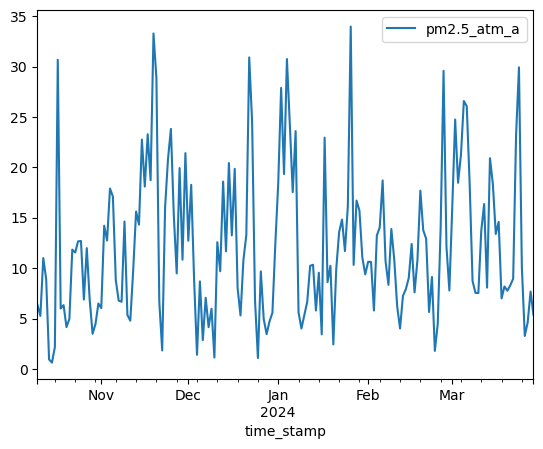

In [96]:
# choose a random sensor
random_sensor = np.random.choice(cleaned_data['sensor_index'].unique())

# plot the data
plt.figure(figsize=(20,10))
chosen_data = cleaned_data[cleaned_data['sensor_index'] == random_sensor]

columns_to_plot = ['pm2.5_atm_a']
chosen_data[columns_to_plot].plot()

In [103]:
chosen_data_1= chosen_data[['pm2.5_atm_a']]

In [104]:
chosen_data_1.reset_index(drop=False, inplace=True)
# make time_stamp datetime
chosen_data_1['time_stamp'] = pd.to_datetime(chosen_data_1['time_stamp'])
chosen_data_1

/tmp/ipykernel_943598/3527228027.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_data_1['time_stamp'] = pd.to_datetime(chosen_data_1['time_stamp'])


,time_stamp,pm2.5_atm_a
0,2023-10-10,6.355
1,2023-10-11,5.265
2,2023-10-12,11.000
3,2023-10-13,8.920
4,2023-10-14,0.947
...,...,...
167,2024-03-25,10.064
168,2024-03-26,3.279
169,2024-03-27,4.622
170,2024-03-28,7.680


In [105]:
chosen_data_1.dtypes

time_stamp     datetime64[ns]
pm2.5_atm_a           float64
dtype: object

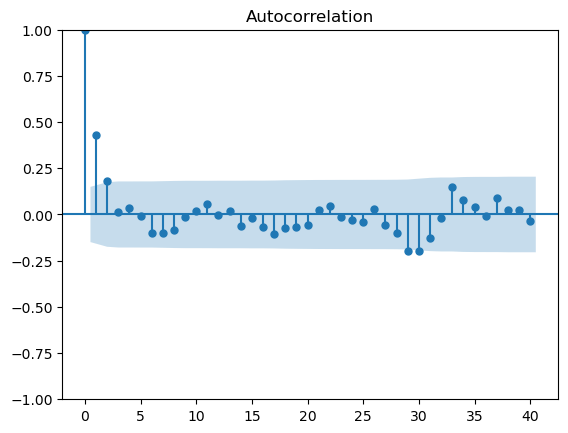

In [106]:
import statsmodels.api as sm
del chosen_data_1["time_stamp"]
sm.graphics.tsa.plot_acf(chosen_data_1.values.squeeze(), lags=40)
plt.show()


ACF only significant for lag 1. ACF is often used to determine the order of moving average in ARMA models. 

This suggests an MA of order 1 might be appropriate. 

AUGMENTED DICKEY-FULLER TEST to check for stationarity.

In [20]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

result = adfuller(chosen_data['pm2.5_atm_a'])

In [21]:
print(result[1])

3.194480469198936e-26


IN adfuller, null hypothesis is the data is non-stationary


So we can safely reject the null hypothesis in favor of alternate hypothesis " the time series data we have is stationary"

No differencing is needed ( d= 0)

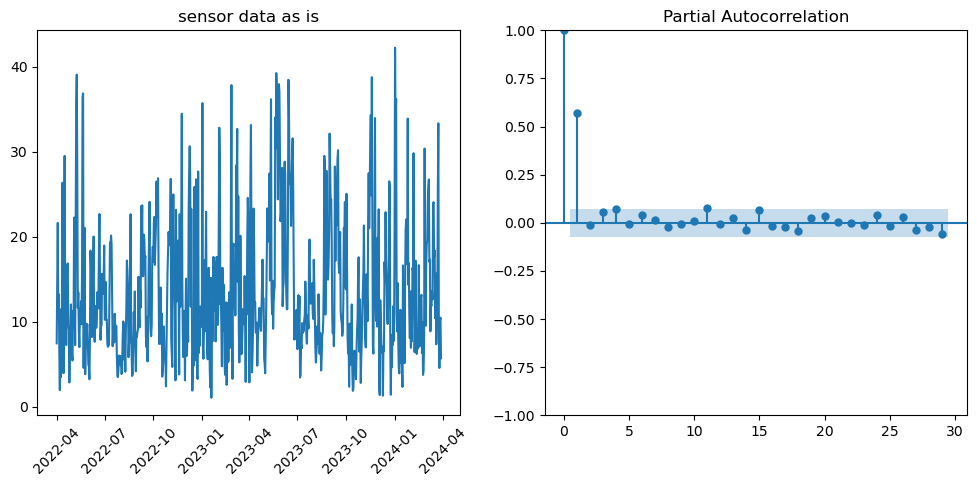

In [23]:
f = plt.figure(figsize=(12,5))
ax1 = f.add_subplot(121)
ax1.set_title('sensor data as is')
ax1.plot(chosen_data['pm2.5_atm_a'])
ax1.xaxis.set_tick_params(rotation=45)

ax2 = f.add_subplot(122)
plot_pacf(chosen_data['pm2.5_atm_a'].dropna(), ax = ax2)
plt.show()

lag of 1 is appropriate. SO AR(1) model may be appropriate

In [49]:
from statsmodels.tsa.ar_model import AutoReg

# Get the data
data = chosen_data['pm2.5_atm_a']
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')  # Explicitly set the frequency to daily
# data.index = data.index.to_period('D')
start_date = '2024-01-08'
train_data = data[:start_date]
test_data = data[start_date:]
# Fit the AR(1) model
model = AutoReg(train_data, lags=1)
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:            pm2.5_atm_a   No. Observations:                  648
Model:                     AutoReg(1)   Log Likelihood               -2135.193
Method:               Conditional MLE   S.D. of innovations              6.561
Date:                Sun, 25 Aug 2024   AIC                           4276.387
Time:                        16:03:16   BIC                           4289.804
Sample:                    04-02-2022   HQIC                          4281.592
                         - 01-08-2024                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.6595      0.508     11.148      0.000       4.664       6.654
pm2.5_atm_a.L1     0.5888      0.032     18.532      0.000       0.527       0.651
                                    

In [50]:
test_data.index = test_data.index.to_period('D')

In [51]:
test_data.index[-1]

Period('2024-03-29', 'D')

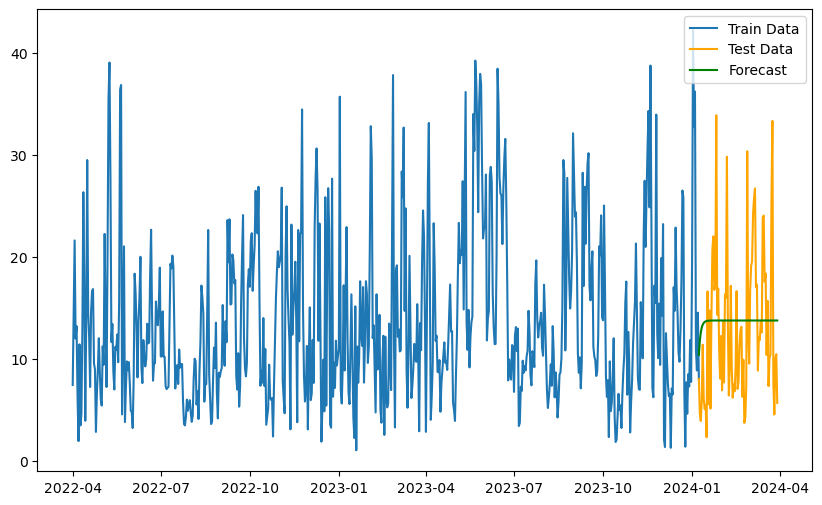

In [52]:
forecast = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.plot(test_data.index, forecast, label='Forecast', color='green')
plt.legend()
plt.show()


A simple AR model did not capture the variablilty in the data.